In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [2]:

# Load the CSV file into a DataFrame
data = pd.read_csv("../data/train.csv",dtype={'StateHoliday': str})

In [3]:
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d').dt.strftime('%Y-%m-%d')


In [4]:
data.head(3)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1


In [5]:
print(data.dtypes)

Store             int64
DayOfWeek         int64
Date             object
Sales             int64
Customers         int64
Open              int64
Promo             int64
StateHoliday     object
SchoolHoliday     int64
dtype: object


In [6]:
# Define the mapping dictionary
holiday_mapping = {"a": 1, "b": 2, "c": 3, "0": 0}

# Map the values in the "StateHoliday" column to integers
data["StateHoliday"] = data["StateHoliday"].map(holiday_mapping)

In [7]:
# Check for NaN values
print(data.isna().sum())


Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64


In [8]:
data['Date'] = pd.to_datetime(data['Date'])
data['DayOfWeek'] = pd.to_datetime(data['Date']).dt.dayofweek
# Extract weekdays and weekends
data['Weekday'] = data['DayOfWeek'].apply(lambda x: 1 if x < 5 else 0)
data['Weekend'] = data['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)
# Extract beginning, mid, and end of the month
data['BeginningOfMonth'] = data['Date'].dt.day.apply(lambda x: 1 if x <= 10 else 0)
data['MidMonth'] = data['Date'].dt.day.apply(lambda x: 1 if x > 10 and x <= 20 else 0)
data['EndOfMonth'] = data['Date'].dt.day.apply(lambda x: 1 if x > 20 else 0)

In [9]:
data.head(3)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Weekday,Weekend,BeginningOfMonth,MidMonth,EndOfMonth
0,1,4,2015-07-31,5263,555,1,1,0,1,1,0,0,0,1
1,2,4,2015-07-31,6064,625,1,1,0,1,1,0,0,0,1
2,3,4,2015-07-31,8314,821,1,1,0,1,1,0,0,0,1


Scaling

In [10]:
columns_to_exclude = ['Date']
columns_to_scale = [column for column in data.columns if column not in columns_to_exclude]
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[columns_to_scale])
data[columns_to_scale] = scaled_data

In [11]:
data.head(3)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Weekday,Weekend,BeginningOfMonth,MidMonth,EndOfMonth
0,-1.731640,0.501484,2015-07-31,-0.132683,-0.168269,0.452399,1.273237,-0.159217,2.144211,0.630672,-0.630672,-0.700515,-0.700517,1.388213
1,-1.728534,0.501484,2015-07-31,0.075373,-0.017540,0.452399,1.273237,-0.159217,2.144211,0.630672,-0.630672,-0.700515,-0.700517,1.388213
2,-1.725427,0.501484,2015-07-31,0.659800,0.404499,0.452399,1.273237,-0.159217,2.144211,0.630672,-0.630672,-0.700515,-0.700517,1.388213


 Building models with sklearn pipelines

In [12]:
# Separate the features and target variable
X = data.drop("Sales", axis=1)
y = data["Sales"]

# Define the column transformer for preprocessing
preprocessor = ColumnTransformer([
    ("num_transformer", StandardScaler(), ["Store", "DayOfWeek", "Customers", "Open", "Promo", "SchoolHoliday"]),
    ("cat_transformer", OneHotEncoder(), ["StateHoliday"])
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
# Create the pipeline
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor())
])


In [14]:
# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = pipeline.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared Score:", r2)

Mean Squared Error: 0.02728381816109939
R-squared Score: 0.9726550773248893


Mean Squared Error: 0.027282673681253047
R-squared Score: 0.9726562243678991


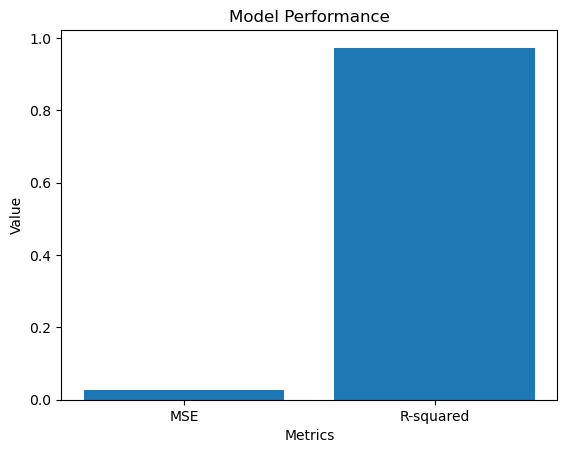

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = pipeline.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared Score:", r2)

# Plotting the metrics
x_labels = ["MSE", "R-squared"]
y_values = [mse, r2]

plt.bar(x_labels, y_values)
plt.xlabel("Metrics")
plt.ylabel("Value")
plt.title("Model Performance")
plt.show()

"Discounted Sales Loss" (DSL)

I added a custom loss function called mean_absolute_percentage_error that calculates the MAPE between the true sales values (y_true) and the predicted sales values (y_pred). The MAPE is then printed alongside the Mean Squared Error and R-squared score.

By using MAPE as the loss function, we can evaluate the model's performance in terms of the percentage error, which provides a more intuitive understanding of the prediction accuracy. It allows us to easily interpret the average percentage deviation of the predicted sales from the true sales values. A lower MAPE indicates a better model fit.

In [15]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Define a custom loss function - Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Separate the features and target variable
X = data.drop("Sales", axis=1)
y = data["Sales"]

# Define the column transformer for preprocessing
preprocessor = ColumnTransformer([
    ("num_transformer", StandardScaler(), ["Store", "DayOfWeek", "Customers", "Open", "Promo", "SchoolHoliday"]),
    ("cat_transformer", OneHotEncoder(), ["StateHoliday"])
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the pipeline
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor())
])

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = pipeline.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared Score:", r2)
print("Mean Absolute Percentage Error:", mape)

Mean Squared Error: 0.027248994755304307
R-squared Score: 0.972689978720769
Mean Absolute Percentage Error: 103.46544127185126


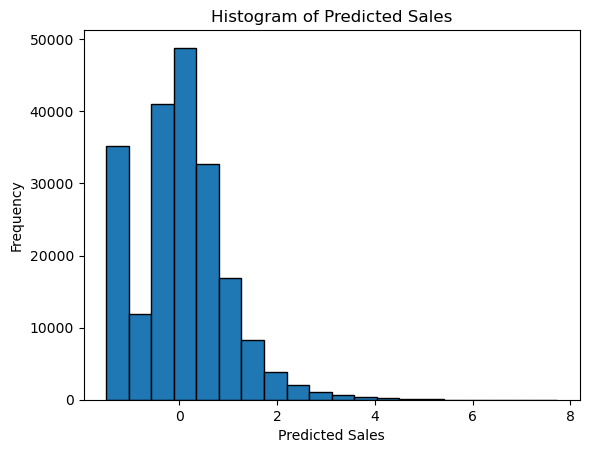

In [20]:


# Create a histogram of the predicted sales values
plt.hist(y_pred, bins=20, edgecolor='black')

# Set the labels and title
plt.xlabel('Predicted Sales')
plt.ylabel('Frequency')
plt.title('Histogram of Predicted Sales')

# Display the histogram
plt.show()

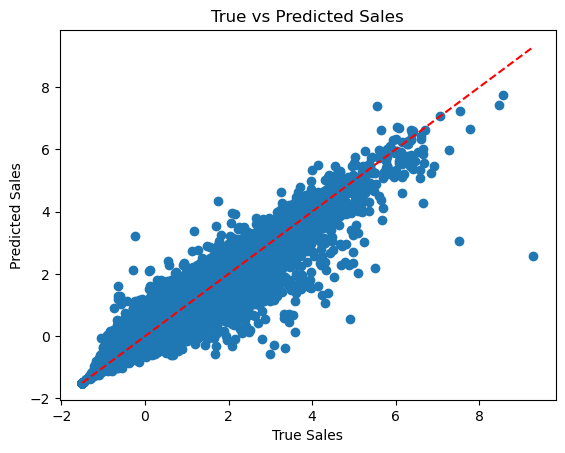

In [16]:


# Plot the predicted sales values against the true sales values
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel('True Sales')
plt.ylabel('Predicted Sales')
plt.title('True vs Predicted Sales')
plt.show()

Post Prediction Analysis

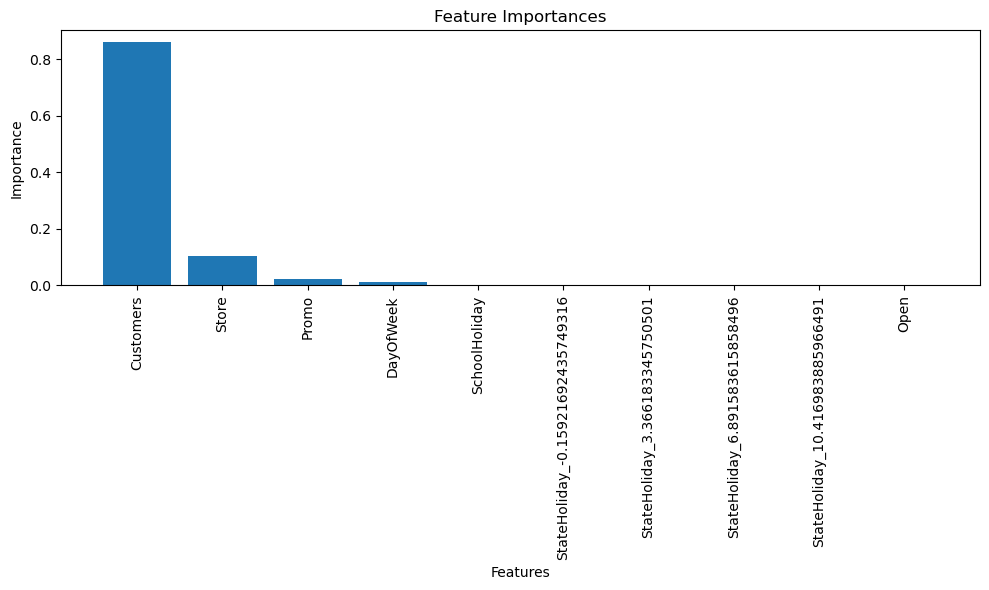

In [17]:


# Get feature importances from the trained model
feature_importances = pipeline.named_steps["regressor"].feature_importances_

# Get the names of the features after preprocessing
encoded_columns = pipeline.named_steps["preprocessor"].transformers_[1][1].get_feature_names_out(["StateHoliday"])
feature_names = list(pipeline.named_steps["preprocessor"].transformers_[0][2]) + list(encoded_columns)

# Sort feature importances in descending order
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_importances = feature_importances[sorted_indices]
sorted_feature_names = [feature_names[idx] for idx in sorted_indices]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.bar(sorted_feature_names, sorted_importances)
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importances")
plt.tight_layout()
plt.show()

To estimate the confidence interval of  predictions, one approach is to use bootstrapping. Bootstrapping is a resampling technique that involves repeatedly sampling your dataset with replacement and fitting the model on each resampled dataset to generate a distribution of predictions.

In [ ]:
# Number of bootstrap samples
n_bootstrap = 100

# Generate bootstrap samples and store predictions
bootstrapped_predictions = []
for _ in range(n_bootstrap):
    # Resample with replacement
    bootstrap_indices = np.random.choice(len(X_test), size=len(X_test), replace=True)
    X_bootstrap = X_test.iloc[bootstrap_indices]
    y_bootstrap = y_test.iloc[bootstrap_indices]
    
    # Make predictions on the bootstrap sample
    y_pred_bootstrap = pipeline.predict(X_bootstrap)
    bootstrapped_predictions.append(y_pred_bootstrap)

# Calculate the confidence interval
confidence_interval = np.percentile(bootstrapped_predictions, [2.5, 97.5], axis=0)

print("Confidence Interval (95%):", confidence_interval)